In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.


In [2]:
import tensorflow as tf
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [3]:
path = "tiramisu_data/"

In [4]:
images_path = path + 'img/'
labels_path = path + 'mask/'

In [5]:
images = glob.glob(images_path + '*.jpg')
print (images[:3])

labels = [labels_path + os.path.basename(i)[:-4] + '.png' for i in images]
print (labels[:3])

['tiramisu_data/img/BloodImage_00348.jpg', 'tiramisu_data/img/BloodImage_00150.jpg', 'tiramisu_data/img/BloodImage_00074.jpg']
['tiramisu_data/mask/BloodImage_00348.png', 'tiramisu_data/mask/BloodImage_00150.png', 'tiramisu_data/mask/BloodImage_00074.png']


In [6]:
image_size = (640,480)

In [7]:
def open_image(img):
    return np.array(Image.open(img).resize(image_size, Image.NEAREST))

In [8]:
imgs = np.stack([open_image(i) for i in images])
imgs.shape

(314, 480, 640, 3)

In [9]:
fnames = glob.glob(images_path+'*.jpg')

In [10]:
img = Image.open(fnames[1]).resize(image_size, Image.NEAREST)

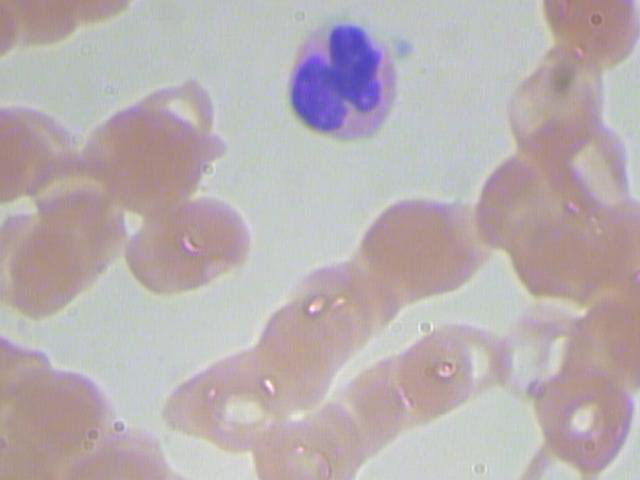

In [11]:
img

In [12]:
lbs = np.stack([open_image(l) for l in labels])
lbs.shape

(314, 480, 640, 3)

In [13]:
imgs = imgs/255.

In [14]:
mean = imgs.mean() 
std = imgs.std()
mean, std

(0.71533231343310844, 0.083957608412733961)

In [15]:
imgs-=imgs.mean()
imgs/=imgs.std()

In [35]:
# save_array('imgs.bc', imgs)
# save_array('lbs.bc', labels)

In [16]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [17]:
bi = BatchIndices(10,3, True)
[next(bi) for o in range(5)]

[array([0, 3, 7]),
 array([5, 8, 2]),
 array([4, 1, 6]),
 array([9]),
 array([8, 6, 0])]

In [18]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

In [19]:
sg = segm_generator(imgs, lbs, 4, train=False)
b_img, b_label = next(sg)

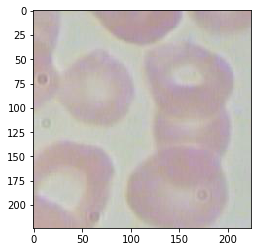

In [20]:
plt.imshow(b_img[0]*0.08+0.7);

In [170]:
def parse_code(l):
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

In [171]:
label_codes, label_names = zip(*[parse_code(l) for l in open('MASK_2_WBC_U_NET/'+"label_color.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

len(label_names)

2

In [172]:

label_codes, label_names

([(255, 0, 0), (255, 255, 0)], ['Smear', 'WBC'])

In [173]:
code2id = {v:k for k,v in enumerate(label_codes)}

id2code = {k:v for k,v in enumerate(label_codes)}

In [174]:
code2id

{(255, 0, 0): 0, (255, 255, 0): 1}

In [175]:
failed_code = len(label_codes)+1
failed_code

3

In [143]:
n,r,c,ch = imgs.shape
n, r, c, ch

(314, 480, 640, 3)

In [144]:
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[tuple(lbs[i,j,k])]
            except: res[j,k] = failed_code
    return res

In [145]:
from concurrent.futures import ProcessPoolExecutor

In [146]:
def conv_all_labels():
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(conv_one_label, range(n)))

In [147]:
labels_int = conv_all_labels()

In [148]:
labels_int.shape

(314, 480, 640)

In [149]:
np.count_nonzero(labels_int==failed_code)

203040

In [150]:
l = []
for i in range(len(labels_int)):
    if np.count_nonzero(labels_int[i]==failed_code) > 0:
        l.append(i)

print (len(l))

314


In [151]:
#l

In [169]:
labels_int = np.delete(labels_int, l, axis=0)
len(labels_int)

0

In [153]:
labels_int.shape

(314, 480, 640)

In [154]:
np.count_nonzero(labels_int==failed_code)

203040

In [155]:
#imgs = np.delete(imgs, l, axis=0)
len(imgs)

314

In [156]:
def color_label(a): 
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            var = id2code[a[j,k]]
            res[j,k] = var
    return res

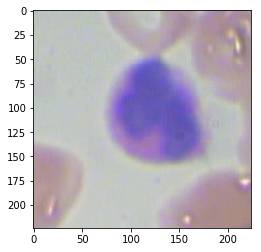

In [157]:
sg = segm_generator(imgs, lbs, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.08+0.7)

In [158]:
# b_label[0]

In [168]:
def dict_color_label(x):
    l = [code2id[tuple(i)] for i in x]
    l = np.array(l)
    return l

TypeError: Image data can not convert to float

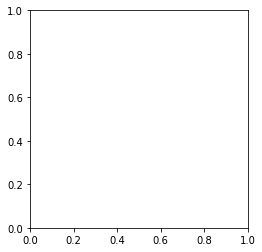

In [162]:
temp = dict_color_label(b_label[0])
plt.imshow(np.resize(temp, (224,224)))

## Creating Test Set

In [163]:
train_set = imgs[:280]
train_labels = labels_int[:280]

test_set = imgs[280:]
test_labels = labels_int[280:]

In [164]:
len(train_set), len(test_set), len(train_labels), len(test_labels)

(280, 34, 280, 34)

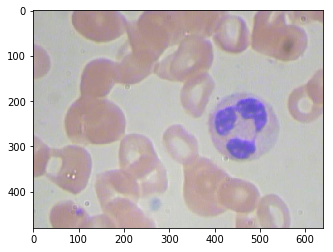

In [165]:
plt.imshow(train_set[162]*0.08+0.7)

In [167]:
plt.imshow(color_label(train_labels[162]))

KeyError: 4

In [99]:
train_labels[0].shape

(480, 640)

In [48]:
train_generator = segm_generator(train_set, train_labels, 3, train=True)
test_generator = segm_generator(test_set, test_labels, 3, train=False)

In [49]:
i,la = next(train_generator)

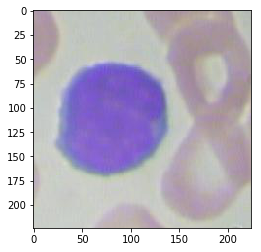

In [50]:
plt.imshow(i[0]*0.08+0.7)

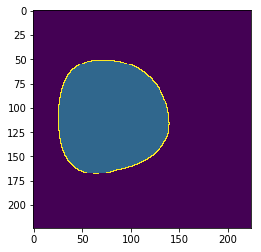

In [51]:
# t = dict_color_label(la[0])
#plt.imshow(color_label(np.resize(la[0], (224,224))))
plt.imshow(np.resize(la[0],(224,224)))

In [52]:
la[0].shape

(50176, 1)

In [87]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=2, axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return merge(xs, mode='concat', concat_axis=-1)

In [88]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                      subsample=(stride,stride), W_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

In [89]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

In [90]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

In [91]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

In [92]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Deconvolution2D(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
               border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

In [93]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

In [94]:
def reverse(a): return list(reversed(a))

In [95]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

In [96]:
input_shape = (224,224,3)
img_input = Input(shape=input_shape)
x = create_tiramisu(2, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [97]:
model = Model(img_input, x)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(0.0001), metrics=["accuracy"])

In [287]:
# train_set[0]

In [98]:
model.fit_generator(train_generator, len(train_set), 100, verbose=1,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/100
 39/280 [===>..........................] - ETA: 244s - loss: nan - acc: 0.8703

KeyboardInterrupt: 

In [262]:
model.save_weights('tiramisu_100_iterations.h5')

In [263]:
#model.optimizer=keras.optimizers.RMSprop(2e-4, decay=1-0.9995)
model.optimizer=keras.optimizers.Adam(0.00001,decay=1-0.9995)

In [264]:
model.fit_generator(train_generator, len(train_set), 500, verbose=1,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/500
280/280 [==============================] - 128s - loss: nan - acc: 0.8905 - val_loss: nan - val_acc: 0.9709
Epoch 2/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8737 - val_loss: nan - val_acc: 0.9709
Epoch 3/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8904 - val_loss: nan - val_acc: 0.9709
Epoch 4/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8830 - val_loss: nan - val_acc: 0.9709
Epoch 5/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8941 - val_loss: nan - val_acc: 0.9709
Epoch 6/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8844 - val_loss: nan - val_acc: 0.9709
Epoch 7/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8957 - val_loss: nan - val_acc: 0.9709
Epoch 8/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8835 - val_loss: nan - val_acc: 0.9709
Epoch 9/500
280/280 [===================

KeyboardInterrupt: 

In [265]:
model.optimizer=keras.optimizers.Adam(0.000001)

In [ ]:
model.fit_generator(train_generator, len(train_set), 500, verbose=1,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/500
280/280 [==============================] - 128s - loss: nan - acc: 0.8905 - val_loss: nan - val_acc: 0.9709
Epoch 2/500
280/280 [==============================] - 124s - loss: nan - acc: 0.9028 - val_loss: nan - val_acc: 0.9709
Epoch 3/500
280/280 [==============================] - 125s - loss: nan - acc: 0.8896 - val_loss: nan - val_acc: 0.9709
Epoch 4/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8748 - val_loss: nan - val_acc: 0.9709
Epoch 5/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8792 - val_loss: nan - val_acc: 0.9709
Epoch 6/500
280/280 [==============================] - 125s - loss: nan - acc: 0.8872 - val_loss: nan - val_acc: 0.9709
Epoch 7/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8919 - val_loss: nan - val_acc: 0.9709
Epoch 8/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8863 - val_loss: nan - val_acc: 0.9709
Epoch 9/500
280/280 [===================

280/280 [==============================] - 125s - loss: nan - acc: 0.8928 - val_loss: nan - val_acc: 0.9709
Epoch 131/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8878 - val_loss: nan - val_acc: 0.9709
Epoch 132/500
280/280 [==============================] - 125s - loss: nan - acc: 0.8782 - val_loss: nan - val_acc: 0.9709
Epoch 133/500
280/280 [==============================] - 125s - loss: nan - acc: 0.9022 - val_loss: nan - val_acc: 0.9709
Epoch 134/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8914 - val_loss: nan - val_acc: 0.9709
Epoch 135/500
280/280 [==============================] - 125s - loss: nan - acc: 0.8966 - val_loss: nan - val_acc: 0.9709
Epoch 136/500
280/280 [==============================] - 125s - loss: nan - acc: 0.8758 - val_loss: nan - val_acc: 0.9709
Epoch 137/500
280/280 [==============================] - 125s - loss: nan - acc: 0.8862 - val_loss: nan - val_acc: 0.9709
Epoch 138/500
280/280 [===============

280/280 [==============================] - 124s - loss: nan - acc: 0.8859 - val_loss: nan - val_acc: 0.9709
Epoch 204/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8836 - val_loss: nan - val_acc: 0.9709
Epoch 205/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8853 - val_loss: nan - val_acc: 0.9709
Epoch 206/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8938 - val_loss: nan - val_acc: 0.9709
Epoch 207/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8805 - val_loss: nan - val_acc: 0.9709
Epoch 208/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8787 - val_loss: nan - val_acc: 0.9709
Epoch 209/500
280/280 [==============================] - 124s - loss: nan - acc: 0.9037 - val_loss: nan - val_acc: 0.9709
Epoch 210/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8884 - val_loss: nan - val_acc: 0.9709
Epoch 211/500
280/280 [===============

KeyboardInterrupt: 

In [267]:
model.optimizer=keras.optimizers.RMSprop(0.0000010, decay=1-0.9995)

In [268]:
model.fit_generator(train_generator, len(train_set), 500, verbose=1,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/500
280/280 [==============================] - 128s - loss: nan - acc: 0.9007 - val_loss: nan - val_acc: 0.9709
Epoch 2/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8838 - val_loss: nan - val_acc: 0.9709
Epoch 3/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8865 - val_loss: nan - val_acc: 0.9709
Epoch 4/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8882 - val_loss: nan - val_acc: 0.9709
Epoch 5/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8906 - val_loss: nan - val_acc: 0.9709
Epoch 6/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8964 - val_loss: nan - val_acc: 0.9709
Epoch 7/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8886 - val_loss: nan - val_acc: 0.9709
Epoch 8/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8827 - val_loss: nan - val_acc: 0.9709
Epoch 9/500
280/280 [===================

280/280 [==============================] - 124s - loss: nan - acc: 0.8856 - val_loss: nan - val_acc: 0.9709
Epoch 69/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8881 - val_loss: nan - val_acc: 0.9709
Epoch 70/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8903 - val_loss: nan - val_acc: 0.9709
Epoch 71/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8941 - val_loss: nan - val_acc: 0.9709
Epoch 72/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8778 - val_loss: nan - val_acc: 0.9709
Epoch 73/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8933 - val_loss: nan - val_acc: 0.9709
Epoch 74/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8976 - val_loss: nan - val_acc: 0.9709
Epoch 75/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8781 - val_loss: nan - val_acc: 0.9709
Epoch 76/500
280/280 [=======================

280/280 [==============================] - 124s - loss: nan - acc: 0.8675 - val_loss: nan - val_acc: 0.9709
Epoch 136/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8906 - val_loss: nan - val_acc: 0.9709
Epoch 137/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8838 - val_loss: nan - val_acc: 0.9709
Epoch 138/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8969 - val_loss: nan - val_acc: 0.9709
Epoch 139/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8930 - val_loss: nan - val_acc: 0.9709
Epoch 140/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8855 - val_loss: nan - val_acc: 0.9709
Epoch 141/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8903 - val_loss: nan - val_acc: 0.9709
Epoch 142/500
280/280 [==============================] - 124s - loss: nan - acc: 0.8867 - val_loss: nan - val_acc: 0.9709
Epoch 143/500
280/280 [===============

KeyboardInterrupt: 

In [269]:
model.optimizer=keras.optimizers.Adam(1e-3, decay=1-0.99995)

In [ ]:
model.fit_generator(train_generator, len(train_set), 50, verbose=1,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/50
280/280 [==============================] - 128s - loss: nan - acc: 0.8904 - val_loss: nan - val_acc: 0.9709
Epoch 2/50
280/280 [==============================] - 124s - loss: nan - acc: 0.8684 - val_loss: nan - val_acc: 0.9709
Epoch 3/50
280/280 [==============================] - 124s - loss: nan - acc: 0.8813 - val_loss: nan - val_acc: 0.9709
Epoch 4/50
280/280 [==============================] - 124s - loss: nan - acc: 0.8882 - val_loss: nan - val_acc: 0.9709
Epoch 5/50
280/280 [==============================] - 124s - loss: nan - acc: 0.9036 - val_loss: nan - val_acc: 0.9709
Epoch 6/50
280/280 [==============================] - 124s - loss: nan - acc: 0.8915 - val_loss: nan - val_acc: 0.9709
Epoch 7/50
280/280 [==============================] - 124s - loss: nan - acc: 0.8964 - val_loss: nan - val_acc: 0.9709
Epoch 8/50
280/280 [==============================] - 124s - loss: nan - acc: 0.8898 - val_loss: nan - val_acc: 0.9709
Epoch 9/50
280/280 [============================

In [273]:
model.save_weights('test.hdf5')

In [272]:
print("Tet")

Tet


In [138]:
model.load_weights('tiramisu_100_iterations.h5')

In [274]:
predictions = model.predict_generator(test_generator, len(test_set))

In [275]:
predictions.shape

(34, 50176, 3)

In [280]:
target=test_labels[:,8:]

In [278]:
plt.imshow(color_label(np.resize(predictions[3], (224,224))))

KeyError: nan

In [1]:
plt.imshow(test_labels[1])

NameError: name 'plt' is not defined

In [103]:
j, t_la = next(test_generator)

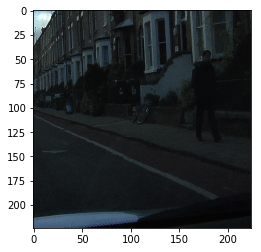

In [104]:
plt.imshow(j[0]*0.3+0.4)

In [59]:
try_image = np.array(Image.open('Seq05VD_f05100.png').resize((224,224), Image.NEAREST))
try_image = try_image/255.
try_image-=mean
try_image/=std
try_image.shape

(224, 224, 3)

In [60]:
try_preds = model.predict(np.expand_dims(try_image, 0), 1)

In [61]:
try_preds = np.argmax(try_preds, axis=-1)
try_preds.shape

(1, 50176)

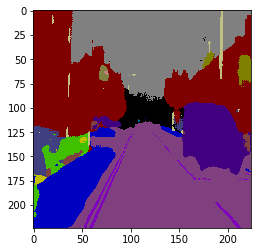

In [62]:
plt.imshow(color_label(np.resize(try_preds[0], (224,224))))
plt.imsave()

In [63]:
image_size

(480, 360)

In [52]:
try_img = np.array(Image.open('Seq05VD_f05100.png').resize(image_size, Image.NEAREST))
try_img = try_img/255.
try_img-=mean
try_img/=std

In [53]:
try_label = np.array(Image.open('Seq05VD_f05100_L.png').resize(image_size, Image.NEAREST))

In [54]:
try_gen = segm_generator(np.expand_dims(try_img, 0), np.expand_dims(try_img, 0), 1, train=False)

In [55]:
prd = model.predict_generator(try_gen, 1)

In [56]:
prd = np.argmax(prd, axis=-1)

In [57]:
prd.shape

(1, 50176)

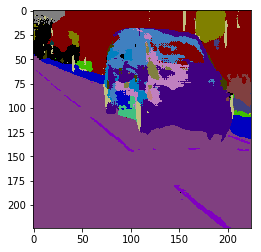

In [58]:
plt.imshow(color_label(np.resize(prd[0], (224,224))))